# CNN For Predicting Welding Quality

In [ ]:
!which python

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import util
import numpy as np
# from resource.config import *
from resource.config import *
from cnn import Cnn
# %matplotlib inline

2024-02-27 21:19:20.214844: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-27 21:19:20.234114: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 21:19:20.234130: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 21:19:20.234145: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-27 21:19:20.237866: I tensorflow/core/platform/cpu_feature_g

In [2]:
from resource.config import *


## Prepare data

Data is a three-dimensional time series consisting of **electrode position, current, and voltage**

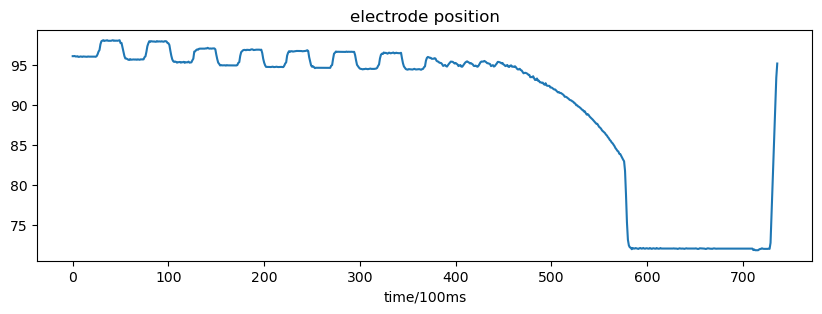

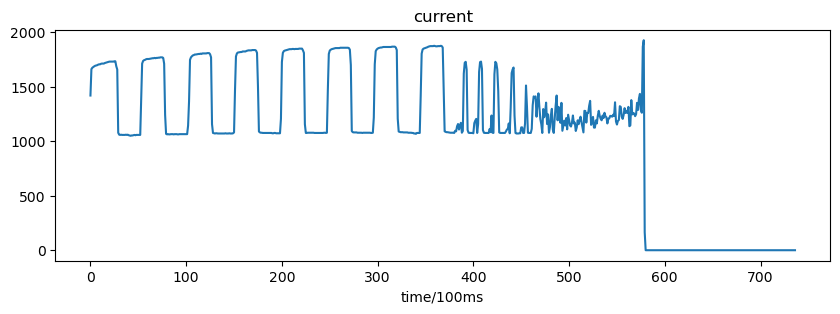

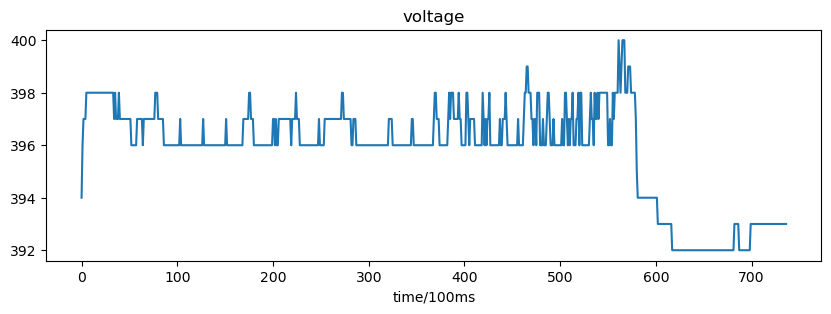

In [3]:
data, num1, num2 = util.load_train_data(50)
plt.figure(figsize=(10, 3), dpi= 100)
plt.xlabel('time/100ms')
plt.title('electrode position')
plt.plot(data[10][:, 0])

plt.figure(figsize=(10, 3), dpi= 100)
plt.xlabel('time/100ms')
plt.title('current')
plt.plot(data[10][:, 1])

plt.figure(figsize=(10, 3), dpi= 100)
plt.xlabel('time/100ms')
plt.title('voltage')
plt.plot(data[10][:, 2])

plt.show()

We use downsampling to make the sequences equal in length. It can be seen that after downsampling to a length of 600, there is not much loss in the characteristics of the data.

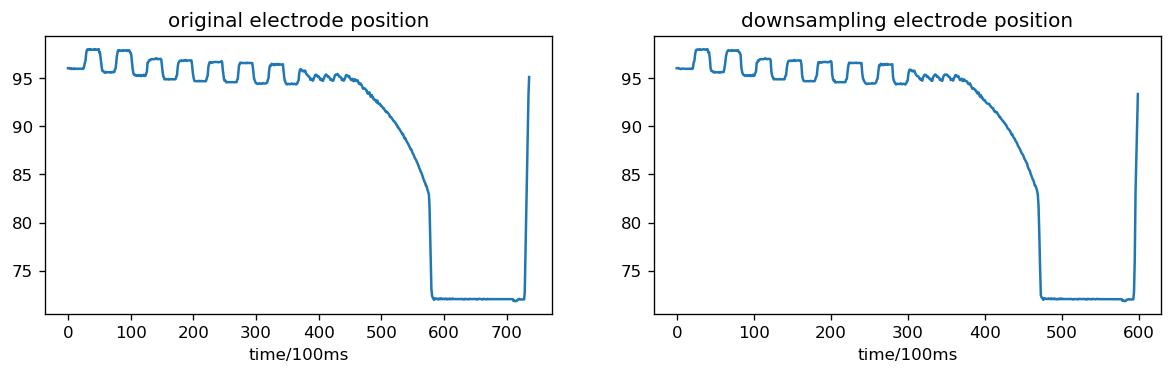

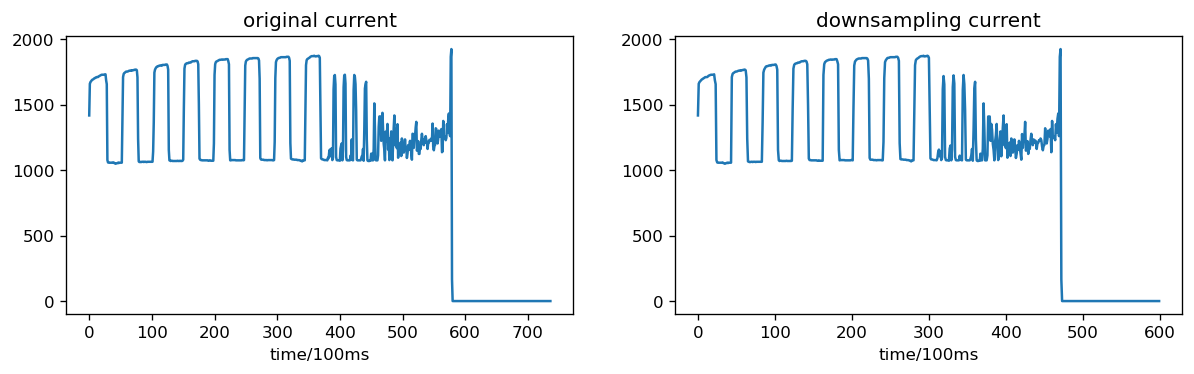

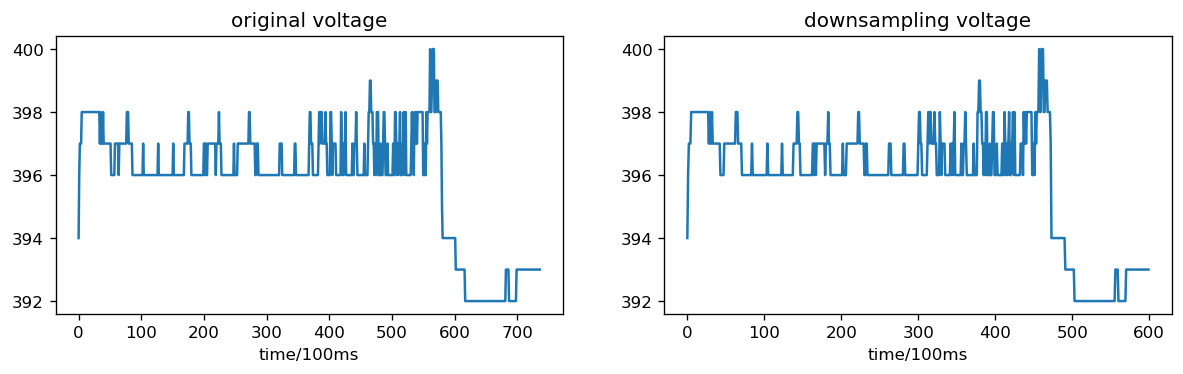

In [4]:
data2, length = util.resample(data, 600)
plt.figure(figsize=(12, 3), dpi= 120)
plt.subplot(121)
plt.title('original electrode position')
plt.xlabel('time/100ms')
plt.plot(data[10][:, 0])
plt.subplot(122)
plt.title('downsampling electrode position')
plt.xlabel('time/100ms')
plt.plot(data2[10][:, 0])

plt.figure(figsize=(12, 3), dpi= 120)
plt.subplot(121)
plt.title('original current')
plt.xlabel('time/100ms')
plt.plot(data[10][:, 1])
plt.subplot(122)
plt.title('downsampling current')
plt.xlabel('time/100ms')
plt.plot(data2[10][:, 1])

plt.figure(figsize=(12, 3), dpi= 120)
plt.subplot(121)
plt.title('original voltage')
plt.xlabel('time/100ms')
plt.plot(data[10][:, 2])
plt.subplot(122)
plt.title('downsampling voltage')
plt.xlabel('time/100ms')
plt.plot(data2[10][:, 2])

plt.show()

## Data Augmentation

Since we only have 50 bad samples, we use ADASYN to expand the number of minority class e.g. bad class.

For more information, you can read my blog about [ADASYN](https://masterwangzx.com/2019/04/08/SMOTE/#adasyn)

In [5]:
# the number of data for train and test, must smaller than 2050
num_data = 1500

In [6]:
data, num_good, num_bad = util.load_train_data(num_data // 2)

# resample
data, length = util.resample(data, 600)
data = util.reshape(data, length)
good_data_origin = data[:num_good, :]
bad_data_origin = data[num_good:, :]

# extract bad data for test and train
permutation = list(np.random.permutation(len(bad_data_origin)))
shuffled_bad_data = bad_data_origin[permutation, :]
test_bad_data = shuffled_bad_data[:int(num_bad * 0.3), :]
train_bad_data_origin = shuffled_bad_data[int(num_bad * 0.3):, :]
# extract corresponding good data for test and train
permutation = list(np.random.permutation(len(good_data_origin)))
shuffled_good_data = good_data_origin[permutation, :]
test_good_data = shuffled_good_data[:len(test_bad_data), :]
train_good_data = shuffled_good_data[len(test_bad_data):, :]

# construct test data
test_y = np.array([1.] * len(test_good_data) + [0.] * len(test_bad_data), dtype=float).reshape((len(test_bad_data) + len(test_good_data), 1))
test_x = np.vstack((test_good_data, test_bad_data))

# expand the number of bad data for train
train_x = np.vstack((train_good_data, train_bad_data_origin))
train_y = np.array([1.] * len(train_good_data) + [0.] * len(train_bad_data_origin), dtype=float).reshape((len(train_bad_data_origin) + len(train_good_data), 1))
train_x, train_y, num_expand = util.expand(train_x, train_y)

# regularize
for i in range(len(train_x)):
    train_x[i, :, 0] = util.regularize(train_x[i, :, 0])
    train_x[i, :, 1] = util.regularize(train_x[i, :, 1])
    train_x[i, :, 2] = util.regularize(train_x[i, :, 2])
for i in range(len(test_x)):
    test_x[i, :, 0] = util.regularize(test_x[i, :, 0])
    test_x[i, :, 1] = util.regularize(test_x[i, :, 1])
    test_x[i, :, 2] = util.regularize(test_x[i, :, 2])

# random
train_x, train_y = util.shuffle_data(train_x, train_y)

# Hyperparameters

In [7]:
# numbers of neurons in each convolution layer, 0 is the max pool, -1 is the dropout
conv_layers = [18, 0, 36, 0, 72, -1, 0, 144, -1]

# (filter size, step, pad) in filters in each layers. For pad, fill in 'SAME' or 'VALID'.
# Must correspond to conv_layers. If it is dropout, fill with 0
filters = [(2, 1, 'SAME'), (2, 2, 'SAME'), (2, 1, 'SAME'), (2, 2, 'SAME'), (2, 1, 'SAME'), 0, (2, 2, 'SAME'), (2, 1, 'SAME'), 0]

# the dims of full connected layers. The last layer is 1 and you do not need to write it on. Already implement dropout.
fc_layers = []

learning_rate = 0.00075

# max epochs
num_epochs = 200

# 0->disable
mini_batch_size = 64

# dropout
keep_prob = 0.3

## Construct CNN

In [8]:
graph = tf.Graph()

with graph.as_default():
    cnn = Cnn(conv_layers, fc_layers, filters, learning_rate)
    (m, n_W0, n_C0) = train_x.shape
    n_y = train_y.shape[1]
    
    cnn.initialize(n_W0, n_C0, n_y)
    cost = cnn.cost()
    optimizer = cnn.get_optimizer(cost)
    predict, accuracy = cnn.predict()

## Train

Stop when test accuracy > 0.96 and train accuracy >0.99

In [10]:
with tf.compat.v1.Session(graph=graph) as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    cost_log = []
    test_log = []
    train_log = []
    x = []
    for i in range(1, num_epochs + 1):
        if mini_batch_size != 0:
            num_mini_batches = int(m / mini_batch_size)
            mini_batches = util.random_mini_batches(train_x, train_y, mini_batch_size)

            cost_value = 0
            for mini_batch in mini_batches:
                (mini_batch_x, mini_batch_y) = mini_batch
                _, temp_cost = sess.run([optimizer, cost], feed_dict={cnn.x: mini_batch_x, cnn.y: mini_batch_y, cnn.keep_prob: keep_prob})
                cost_value += temp_cost
            cost_value /= num_mini_batches
        else:
            _, cost_value = sess.run([optimizer, cost], feed_dict={cnn.x: train_x, cnn.y: train_y, cnn.keep_prob: keep_prob})

        # disable dropout
        train_accuracy = sess.run(accuracy, feed_dict={cnn.x: train_x, cnn.y: train_y, cnn.keep_prob: 1})
        test_accuracy = sess.run(accuracy, feed_dict={cnn.x: test_x, cnn.y: test_y, cnn.keep_prob: 1})
        
        x.append(i)
        cost_log.append(cost_value)
        test_log.append(test_accuracy)
        train_log.append(train_accuracy)
        
        if print_detail and (i % 10 == 0 or i == 1):
            print('Iteration %d' % i)
            print('Cost: %f' % cost_value)
            print('Train accuracy: %f' % train_accuracy)
            print('Test accuracy: %f' % test_accuracy)
            print()

        # stop when test>0.95 and train>0.99
        if test_accuracy >= 0.95 and train_accuracy >= 0.99:
            print('Iteration %d' % i)
            print('Cost: %f' % cost_value)
            print('Train accuracy: %f' % train_accuracy)
            print('Test accuracy: %f' % test_accuracy)
            print()
            break

2024-02-27 21:20:40.664377: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-27 21:20:40.667080: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-27 21:20:40.667182: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Iteration 1
Cost: 4.046987
Train accuracy: 0.498982
Test accuracy: 0.500000

Iteration 10
Cost: 0.288433
Train accuracy: 0.960625
Test accuracy: 0.966667

Iteration 20
Cost: 0.164972
Train accuracy: 0.980991
Test accuracy: 1.000000

Iteration 30
Cost: 0.116544
Train accuracy: 0.979633
Test accuracy: 1.000000

Iteration 40
Cost: 0.089536
Train accuracy: 0.988459
Test accuracy: 0.966667

Iteration 50
Cost: 0.071669
Train accuracy: 0.986422
Test accuracy: 1.000000

Iteration 53
Cost: 0.069598
Train accuracy: 0.990496
Test accuracy: 0.966667



## Chart

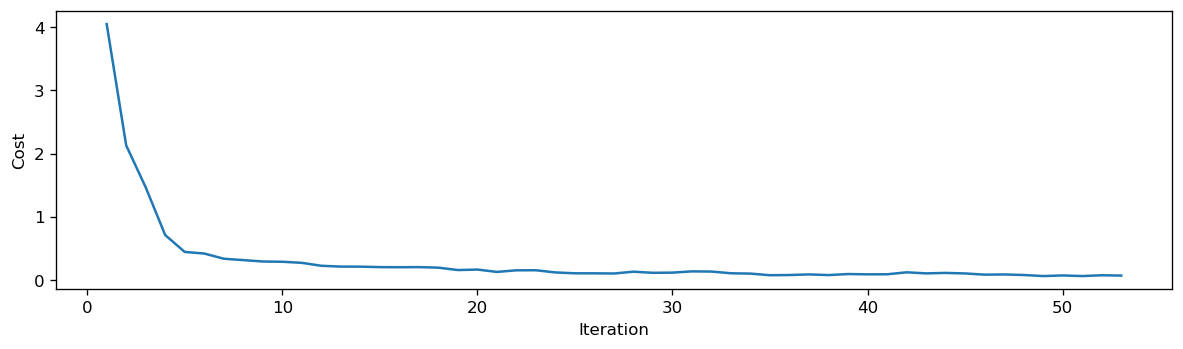

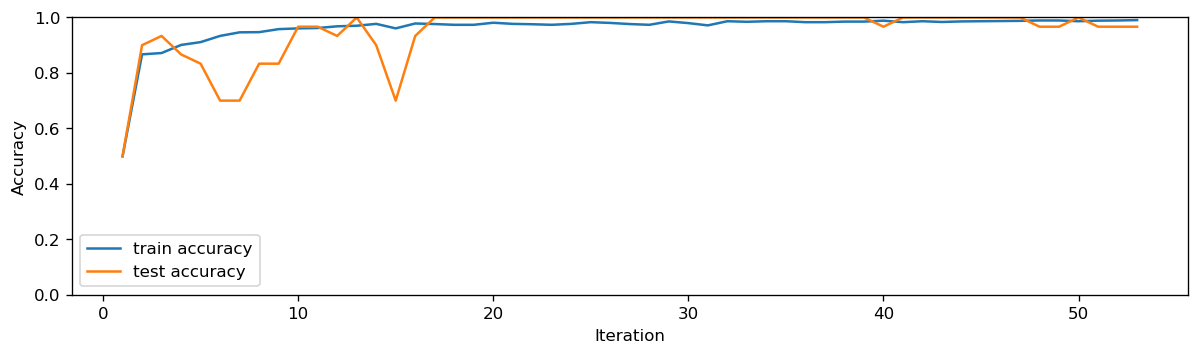

In [11]:
plt.figure(figsize=(12, 3), dpi= 120)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.plot(x, cost_log)

plt.figure(figsize=(12, 3), dpi= 120)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.plot(x, train_log, label='train accuracy')
plt.plot(x, test_log, label='test accuracy')
plt.legend()

plt.show()